# Predict Animation Movies' Revenues

### Scrape from IMDB

In [4]:
from __future__ import print_function, division

In [531]:
# Import packages

import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pprint import pprint
import pandas as pd
import collections
import matplotlib.pyplot as plt
import re
from datetime import datetime
import pickle
import sklearn
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
import numpy as np
from sklearn import linear_model, preprocessing
import patsy
import statsmodels.api as sm
import os,sys
from scipy import stats
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sns

import pandas as pd

%matplotlib inline

In [24]:
pd.options.mode.chained_assignment = None

In [6]:
# Sample Url

sample_url = 'http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page={}&ref_=adv_prv'

In [7]:
# Convert links from tag to list

def imdb_find_all_links(url):
    link_list = []
    response = requests.get(url)
    response.status_code
    page = response.text
    soup = BeautifulSoup(page,"lxml")
    for link in soup.find_all('a'): 
        link_list.append(str(link))
    return link_list

In [8]:
# Extract 50 movie links from each page

def imdb_find_movie_link(url):
    title_list = []
    for link in imdb_find_all_links(url):
        if link.find('a href="/title/') != -1 and link.find('vote') == -1 and link.find('plot') == -1:    
            start = link.find('a href="/title/')
            end = link.find('?',start+1)
            title = (link[start+8:end])
            title = 'http://www.imdb.com' + title
            if title not in title_list:
                title_list.append(title)
        else:
            continue
    return title_list

In [9]:
# Add movie title

def movie_title(url_base):
    html = urlopen(url_base)
    soup = BeautifulSoup(html, 'lxml')
    return str(soup.find('title').string)

In [10]:
# Explore movie rating

def movie_rating(url_base):
    html = urlopen(url_base)
    soup = BeautifulSoup(html, 'lxml')
    return str(soup.find('span', class_ = "rating"))

In [11]:
# Explore movie MPAA

def movie_mpaa(url_base):
    html = urlopen(url_base)
    soup = BeautifulSoup(html, 'lxml')
    return str(soup.find('meta', itemprop = "contentRating"))[15:17]

In [12]:
# Explore awards

def movie_awards(url_base):
    temp = []
    html = urlopen(url_base)
    soup = BeautifulSoup(html, 'lxml')
    test = soup.findAll('span', itemprop = "awards")
    for sublist in test:
        temp.append(sublist.getText().replace('\n', '').replace('   ',''))
    return str(temp)

In [13]:
# Explore the 'Details' section
# Extract info about budget, country, gross, language, production co, release date, runtime

def movie_details(url_base):
    # Read Url
    html = urlopen(url_base)
    # Create Soup
    soup = BeautifulSoup(html, 'lxml')
    test = soup.findAll('div',class_='txt-block')
    temp = []
    for sublist in test:
        for phrase in sublist.findAll('h4',class_='inline'):
            label = phrase.getText().replace(':','')
            text = phrase.nextSibling
            if len(text.strip()) == 0:
                next_text = text.nextSibling.getText().strip()
                temp.append((label,next_text))
            else:
                text = text.replace('        \n\n      ','')
                text = text.replace('(USA)','')
                temp.append((label, text.strip()))

    # Convert List of Tuples to Dictionary
    temp = dict(temp)
    return temp

In [15]:
def compile_data_info(x):
    new_df = pd.DataFrame()
    for link in imdb_find_movie_link(x):
        data = pd.DataFrame.from_dict(movie_details(link),orient='index', dtype=None)
        data = data.transpose()
        data['Movie Title'] = movie_title(link)
        data['Rating Score'] = movie_rating(link)
        data['MPAA'] = movie_mpaa(link)
        data['Awards'] = movie_awards(link)
        new_df = new_df.append(data)
    return new_df

#### Render pages into dataframes

In [16]:
imdb_page_1 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=1&ref_=adv_prv')

In [17]:
imdb_page_2 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=2&ref_=adv_prv')

In [18]:
imdb_page_3 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=3&ref_=adv_prv')

In [19]:
imdb_page_4 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=4&ref_=adv_prv')

In [20]:
imdb_page_5 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=5&ref_=adv_prv')

In [21]:
imdb_page_6 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=6&ref_=adv_prv')

In [22]:
imdb_page_7 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=7&ref_=adv_prv')

In [23]:
imdb_page_8 = compile_data_info('http://www.imdb.com/search/title?genres=animation&title_type=feature&sort=boxoffice_gross_us,desc&page=8&ref_=adv_prv')

In [27]:
# Combine 6 dataframes into 1

movies_data_2 = pd.DataFrame()
movies_data_2 = movies_data_2.append(imdb_page_1)
movies_data_2 = movies_data_2.append(imdb_page_2)
movies_data_2 = movies_data_2.append(imdb_page_3)
movies_data_2 = movies_data_2.append(imdb_page_4)
movies_data_2 = movies_data_2.append(imdb_page_5)
movies_data_2 = movies_data_2.append(imdb_page_6)
movies_data_2 = movies_data_2.append(imdb_page_7)
movies_data_2 = movies_data_2.append(imdb_page_8)

In [54]:
movies_data_2

,Also Known As,Aspect Ratio,Awards,Budget,Certificate,Color,Country,Filming Locations,Gross,Language,...,Movie Title,Official Sites,Opening Weekend,Parents Guide,Production Co,Rating Score,Release Date,Runtime,Sound Mix,Taglines
0,Finding Nemo 2,1.85 : 1,"[' Nominated for 1 BAFTA Film Award.', ' A...","$200,000,000",NaN,Color,USA,"Pixar Animation Studios - 1200 Park Avenue, Em...","$486,292,984",English,...,Finding Dory (2016) - IMDb,Official Facebook,"$135,060,273",View content advisory »,Pixar Animation Studios,"<span class=""rating"">7.5<span class=""ofTen"">/1...",17 June 2016,97 min,Dolby Digital,She just kept swimming...
0,Шрек 2,1.85 : 1,"[' Nominated for 2 Oscars.', ' Another16 w...","$150,000,000",NaN,Color,USA,NaN,"$436,471,036",English,...,Shrek 2 (2004) - IMDb,NaN,"$108,037,878",View content advisory »,DreamWorks,"<span class=""rating"">7.2<span class=""ofTen"">/1...",19 May 2004,93 min,DTS,"In summer 2004, they're back for more...."
0,King of the Jungle,1.66 : 1,"[' Won 2 Oscars.', ' Another33 wins & 30 n...","$45,000,000",G,Color,USA,Walt Disney Feature Animation - 500 S. Buena V...,"$422,783,777",English,...,The Lion King (1994) - IMDb,Official Facebook,"£16,650,343(UK)",View content advisory »,Walt Disney Pictures,"<span class=""rating"">8.5<span class=""ofTen"">/1...",24 June 1994,88 min,Dolby SR,The Circle of Life
0,3,1.85 : 1,"[' Won 2 Oscars.', ' Another58 wins & 89 n...","$200,000,000",G,Color,USA,"Pixar Animation Studios - 1200 Park Avenue, Em...","$414,984,497",English,...,Toy Story 3 (2010) - IMDb,Disney [Japan],"$109,000,000",View content advisory »,Walt Disney Pictures,"<span class=""rating"">8.3<span class=""ofTen"">/1...",18 June 2010,103 min,DTS,No toy gets left behind.
0,The Snow Queen,2.35 : 1,"[' Won 2 Oscars.', ' Another72 wins & 57 n...","$150,000,000",NaN,Color,USA,NaN,"$400,736,600",English,...,Frozen (2013) - IMDb,Official Facebook Page,"$67,391,326",View content advisory »,Walt Disney Animation Studios,"<span class=""rating"">7.5<span class=""ofTen"">/1...",27 November 2013,102 min,Dolby Digital,NaN
0,Finding Nemo 3D,1.85 : 1,"[' Won 1 Oscar.', ' Another46 wins & 59 no...","$94,000,000",G,Color,USA,"Pixar Animation Studios - 1200 Park Avenue, Em...","$380,838,870",English,...,Finding Nemo (2003) - IMDb,Disney [Australia],"$70,251,710",View content advisory »,Pixar Animation Studios,"<span class=""rating"">8.1<span class=""ofTen"">/1...",30 May 2003,100 min,DTS-ES,You've never seen fish prepared like this.
0,Untitled Pets Movie,1.85 : 1,['1 win & 7 nominations. '],"$75,000,000",NaN,Color,USA,NaN,"$368,305,960",English,...,The Secret Life of Pets (2016) - IMDb,Official Facebook,"$104,352,905",View content advisory »,Universal Pictures,"<span class=""rating"">6.6<span class=""ofTen"">/1...",8 July 2016,87 min,Dolby Digital,From the humans behind Despicable Me
0,Mi villano favorito 2,1.85 : 1,"[' Nominated for 2 Oscars.', ' Another12 w...","$76,000,000",NaN,Color,USA,NaN,"$368,049,635",English,...,Despicable Me 2 (2013) - IMDb,Official Facebook,"$83,517,315",View content advisory »,Universal Pictures,"<span class=""rating"">7.5<span class=""ofTen"">/1...",3 July 2013,98 min,Dolby Digital,More minions. More despicable.
0,The Untitled Pixar Movie That Takes You Inside...,1.85 : 1,"[' Won 1 Oscar.', ' Another92 wins & 95 no...","$175,000,000",NaN,Color,USA,"Pixar Animation Studios - 1200 Park Avenue, Em...","$356,454,367",English,...,Inside Out (2015) - IMDb,Official Site,"$90,440,272",View content advisory »,Pixar Animation Studios,"<span class=""rating"">8.2<span class=""ofTen"">/1...",19 June 2015,95 min,Dolby Digital,Meet the little voices inside your head.
0,Zootropolis,2.35 : 1,"[' Nominated for 1 Oscar.', ' Another25 wi...","$150,000,000",NaN,Color,USA,Walt Disney Animation Studios - 500 S. Buena V...,"$341,264,012",English,...,Zootopia (2016) - IMDb,Official Facebook,"$75,063,401",View content advisory »,Walt Disney Pictures,"<span class=""rating"">8.1<span class=""ofTen"">/1...",4 March 

In [29]:
# Numer of data points

len(movies_data_2)

400

In [30]:
# Save the data frame into a pickle file

with open('my_data_3.pkl', 'wb') as picklefile:
    pickle.dump(movies_data_2, picklefile)

In [31]:
# Load pickle file

with open('my_data_3.pkl', 'rb') as picklefile: 
    my_old_data = pickle.load(picklefile)

In [35]:
# Read pickle file

movies_data_2 = pd.read_pickle('my_data_3.pkl')

In [36]:
len(movies_data_2)

400

### Process the Data

In [37]:
# Make a copy of movies_data

imdb_data = movies_data_2

In [38]:
# Display dataframe info

imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 0
Data columns (total 21 columns):
Also Known As        393 non-null object
Aspect Ratio         363 non-null object
Awards               400 non-null object
Budget               299 non-null object
Certificate          169 non-null object
Color                399 non-null object
Country              400 non-null object
Filming Locations    119 non-null object
Gross                389 non-null object
Language             398 non-null object
MPAA                 400 non-null object
Movie Title          400 non-null object
Official Sites       316 non-null object
Opening Weekend      320 non-null object
Parents Guide        400 non-null object
Production Co        398 non-null object
Rating Score         400 non-null object
Release Date         399 non-null object
Runtime              338 non-null object
Sound Mix            363 non-null object
Taglines             315 non-null object
dtypes: object(21)
memory usage: 68.

In [39]:
# Drop data points outside of USA

imdb_data = imdb_data[imdb_data['Country'] == 'USA']

In [40]:
# Drop data points with no rating values

imdb_data = imdb_data[imdb_data['Rating Score'] != 'None']

In [41]:
len(imdb_data)

253

In [42]:
# Remove contents in parenthesis for release date

for n in range(len(imdb_data['Release Date'])):
    if imdb_data['Release Date'].iloc[n].find('(') != -1:
        position = imdb_data['Release Date'].iloc[n].find('(')
        imdb_data['Release Date'].iloc[n] = imdb_data['Release Date'].iloc[n][:position]
    else:
        continue

In [43]:
# Convert release date to date object and extract year, month and day

imdb_data['Release Date'] = pd.to_datetime(imdb_data['Release Date'])
imdb_data['Release Year'] =imdb_data['Release Date'].dt.year
imdb_data['Release Month'] = imdb_data['Release Date'].dt.month
imdb_data['Release Day'] = imdb_data['Release Date'].dt.day

In [44]:
# Add ordinal of the release dates

imdb_data['Release Date Ordinal'] = imdb_data['Release Date'].apply(lambda x: x.toordinal())

In [45]:
# Add day of the week for release date

imdb_data['Release Date Ordinal'] = imdb_data['Release Date'].apply(lambda x: x.toordinal())

In [46]:
# Remove contents in brackets for rating score

for n in range(len(imdb_data['Rating Score'])):
    if imdb_data['Rating Score'].iloc[n].find('>') != -1:
        start = imdb_data['Rating Score'].iloc[n].find('>')
        end = imdb_data['Rating Score'].iloc[n].find('<', start+1)
        imdb_data['Rating Score'].iloc[n] = imdb_data['Rating Score'].iloc[n][start+1:end]
    else:
        continue

In [47]:
# Remove contents in parenthesis for opening weekend

for n in range(len(imdb_data['Opening Weekend'])):
    if str(imdb_data['Opening Weekend'].iloc[n]).find('(') != -1:
        position = str(imdb_data['Opening Weekend'].iloc[n]).find('(')
        imdb_data['Opening Weekend'].iloc[n] = str(imdb_data['Opening Weekend'].iloc[n])[:position]
    else:
        continue

In [48]:
# Convert data types
# RUN ONLY ONCE!

imdb_data['Budget'] = imdb_data['Budget'].replace('[\$,]', '', regex=True).astype(float)
imdb_data['Gross'] = imdb_data['Gross'].replace('[\$,]', '', regex=True).astype(float)
imdb_data['Runtime'] = imdb_data['Runtime'].replace('min', '', regex=True).astype(float)
imdb_data['Rating Score'] = imdb_data['Rating Score'].replace('<span class="rating">7.9<span class="ofTen">', '7.9').apply(lambda x: float(x.split('/')[0]))
imdb_data['Opening Weekend'] = imdb_data['Opening Weekend'].replace('[\$,]', '', regex=True).replace('UK', '', regex=True).replace('[\£,]', '', regex=True).astype(float)

In [49]:
# Remove contents in parenthesis for movie title

for n in range(len(imdb_data['Movie Title'])):
    if imdb_data['Movie Title'].iloc[n].find('(') != -1:
        position = imdb_data['Movie Title'].iloc[n].find('(')
        imdb_data['Movie Title'].iloc[n] = imdb_data['Movie Title'].iloc[n][:position]
    else:
        continue

In [554]:
# Drop data points with release date before 1980 (10 of them)

imdb_data = imdb_data[imdb_data['Release Year'] > 1990]

In [555]:
len(imdb_data)

223

In [556]:
# Drop data points with no MPAA info (2 of them)

imdb_data = imdb_data[imdb_data['MPAA'] != 'NO']

In [557]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223 entries, 0 to 0
Data columns (total 29 columns):
Also Known As           219 non-null object
Aspect Ratio            213 non-null object
Awards                  223 non-null object
Budget                  223 non-null float64
Certificate             70 non-null object
Color                   223 non-null object
Country                 223 non-null object
Filming Locations       82 non-null object
Gross                   223 non-null float64
Language                223 non-null object
MPAA                    223 non-null object
Movie Title             223 non-null object
Official Sites          188 non-null object
Opening Weekend         223 non-null float64
Parents Guide           223 non-null object
Production Co           221 non-null object
Rating Score            223 non-null float64
Release Date            223 non-null datetime64[ns]
Runtime                 223 non-null float64
Sound Mix               213 non-null object
Taglin

In [558]:
imdb_data.head()

,Also Known As,Aspect Ratio,Awards,Budget,Certificate,Color,Country,Filming Locations,Gross,Language,MPAA,Movie Title,Official Sites,Opening Weekend,Parents Guide,Production Co,Rating Score,Release Date,Runtime,Sound Mix,Taglines,Release Year,Release Month,Release Day,Release Date Ordinal,Release Date Quarter,Release Date DOW,Awards Result,Size
0,Finding Nemo 2,1.85 : 1,"[' Nominated for 1 BAFTA Film Award.', ' A...",200000000.0,NaN,Color,USA,"Pixar Animation Studios - 1200 Park Avenue, Em...",486292984.0,English,PG,Finding Dory,Official Facebook,135060273.0,View content advisory »,Pixar Animation Studios,7.5,2016-06-17,97.0,Dolby Digital,She just kept swimming...,2016,6,17,736132,2,4,Nominated,Large
0,Шрек 2,1.85 : 1,"[' Nominated for 2 Oscars.', ' Another16 w...",150000000.0,NaN,Color,USA,NaN,436471036.0,English,PG,Shrek 2,NaN,108037878.0,View content advisory »,DreamWorks,7.2,2004-05-19,93.0,DTS,"In summer 2004, they're back for more....",2004,5,19,731720,2,2,Nominated,Medium
0,King of the Jungle,1.66 : 1,"[' Won 2 Oscars.', ' Another33 wins & 30 n...",45000000.0,G,Color,USA,Walt Disney Feature Animation - 500 S. Buena V...,422783777.0,English,"G""",The Lion King,Official Facebook,16650343.0,View content advisory »,Walt Disney Pictures,8.5,1994-06-24,88.0,Dolby SR,The Circle of Life,1994,6,24,728103,2,4,Won,Large
0,3,1.85 : 1,"[' Won 2 Oscars.', ' Another58 wins & 89 n...",200000000.0,G,Color,USA,"Pixar Animation Studios - 1200 Park Avenue, Em...",414984497.0,English,"G""",Toy Story 3,Disney [Japan],109000000.0,View content advisory »,Walt Disney Pictures,8.3,2010-06-18,103.0,DTS,No toy gets left behind.,2010,6,18,733941,2,4,Won,Large
0,The Snow Queen,2.35 : 1,"[' Won 2 Oscars.', ' Another72 wins & 57 n...",150000000.0,NaN,Color,USA,NaN,400736600.0,English,PG,Frozen,Official Facebook Page,67391326.0,View content advisory »,Walt Disney Animation Studios,7.5,2013-11-27,102.0,Dolby Digital,NaN,2013,11,27,735199,4,2,Won,Large


#### Process Categorical Data

In [559]:
# Group months into quarters

import datetime as dt

imdb_data['Release Date Quarter'] = imdb_data['Release Date'].dt.quarter

In [560]:
# Add day of the week for release date

imdb_data['Release Date DOW'] = imdb_data['Release Date'].dt.dayofweek

In [561]:
# Add awards results

imdb_data['Awards Result'] = 'Not'
imdb_data.loc[imdb_data['Awards'].str.contains('Won'), 'Awards Result'] = 'Won'
imdb_data.loc[imdb_data['Awards'].str.contains('Nominated'), 'Awards Result'] = 'Nominated'

In [562]:
# Group productions cos into large, medium and small based on gross 

Large_Cos = imdb_data.groupby(['Production Co']).sum().sort('Gross', ascending = False).index[0:10]
Medium_Cos = imdb_data.groupby(['Production Co']).sum().sort('Gross', ascending = False).index[10:21]
Small_Cos = imdb_data.groupby(['Production Co']).sum().sort('Gross', ascending = False).index[21:]

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [563]:
def add_production_size(production_company):
    if production_company in Large_Cos:
        return 'Large'
    elif production_company in Medium_Cos:
        return 'Medium'
    else:
        return 'Small'

In [564]:
imdb_data['Size'] = imdb_data['Production Co'].apply(lambda x: add_production_size(x))

In [566]:
# Replace missing values with medians or modes

# Fill in budget (27 missing)
# Fill in opening weekend (30 missing)
# Fill in runtime (29 missing)

imdb_data = imdb_data.fillna(imdb_data.median())


### Exploratory Data Analysis

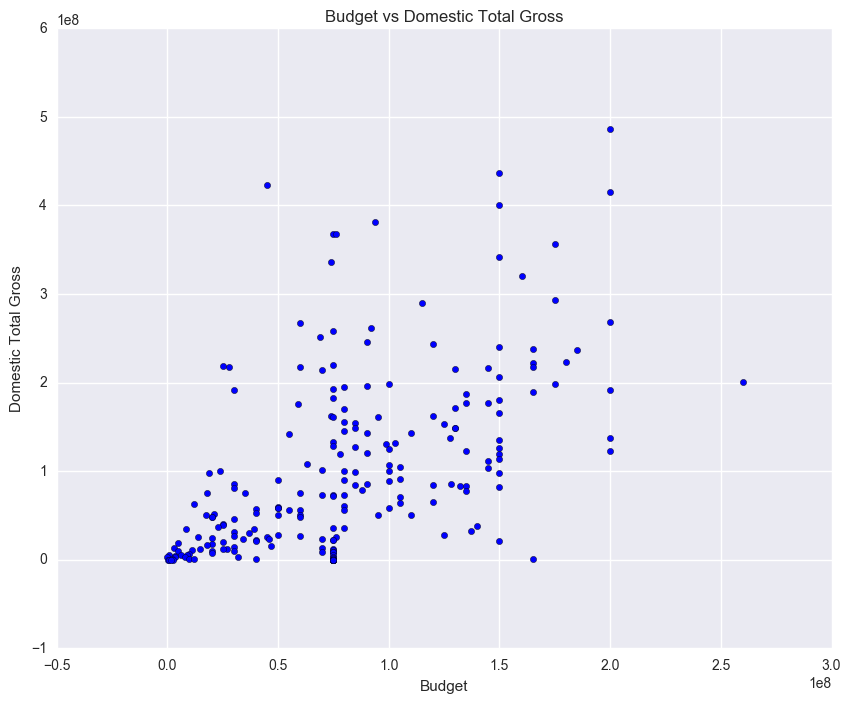

In [568]:
# Budget vs Gross Scatterplot

plt.figure(figsize=(10,8))
plt.scatter(imdb_data['Budget'], imdb_data['Gross'])
plt.xlabel('Budget')
plt.ylabel('Domestic Total Gross')
plt.title('Budget vs Domestic Total Gross')

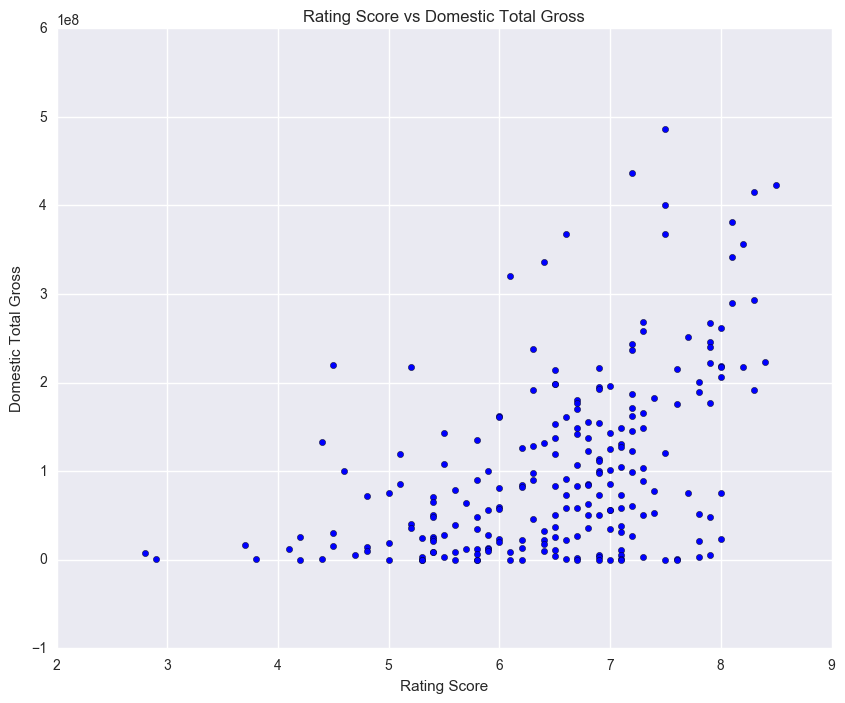

In [569]:
# Rating vs Gross Scatterplot

plt.figure(figsize=(10,8))
plt.scatter(imdb_data['Rating Score'], imdb_data['Gross'])
plt.xlabel('Rating Score')
plt.ylabel('Domestic Total Gross')
plt.title('Rating Score vs Domestic Total Gross')

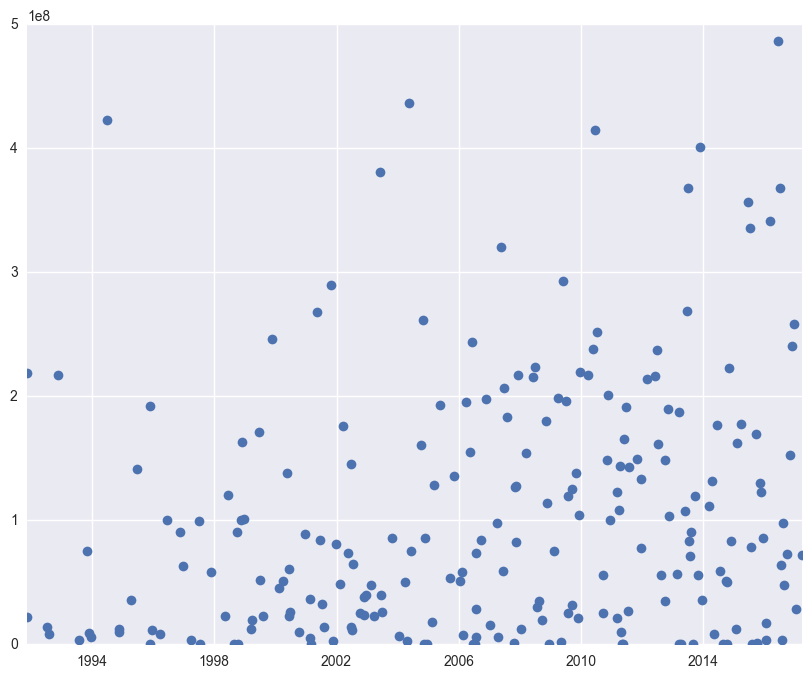

In [570]:
# Gross revenues over time

plt.figure(figsize =(10,8))
plt.plot_date(imdb_data['Release Date'], imdb_data['Gross'])

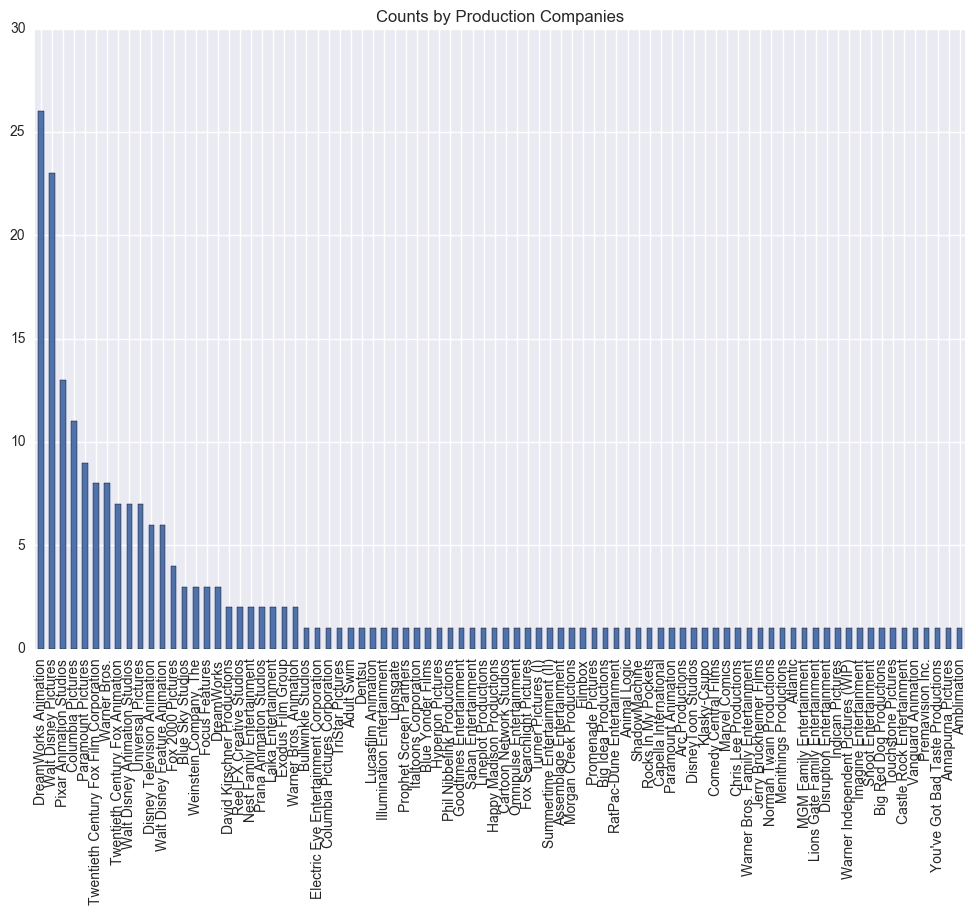

In [571]:
# Bar plots of production co counts

plt.figure(figsize=(12,8))
imdb_data['Production Co'].value_counts().plot(kind='bar')
plt.title('Counts by Production Companies')

### Linear Regression

In [572]:
# Make a copy of imdb_data for modeling

dfm = imdb_data

In [573]:
# Rename features for patsy

dfm = dfm.rename(columns={'Opening Weekend': 'OpeningWeekend', 'Production Co': 'ProductionCo', 'Rating Score': 'RatingScore', 'Release Date Ordinal': 'ReleaseDateOrdinal'})

In [574]:
dfm.columns

Index(['Also Known As', 'Aspect Ratio', 'Awards', 'Budget', 'Certificate',
       'Color', 'Country', 'Filming Locations', 'Gross', 'Language', 'MPAA',
       'Movie Title', 'Official Sites', 'OpeningWeekend', 'Parents Guide',
       'ProductionCo', 'RatingScore', 'Release Date', 'Runtime', 'Sound Mix',
       'Taglines', 'Release Year', 'Release Month', 'Release Day',
       'ReleaseDateOrdinal', 'Release Date Quarter', 'Release Date DOW',
       'Awards Result', 'Size'],
      dtype='object')

In [576]:
# Create dummy variables for MPAA & drop N/A

MPAADummies = pd.get_dummies(dfm['MPAA'])
MPAADummies = MPAADummies.drop('UN',1)
MPAADummies.head()

,,"G""",PG,"R"""
0,0.0,0.0,1.0,0.0
0,0.0,0.0,1.0,0.0
0,0.0,1.0,0.0,0.0
0,0.0,1.0,0.0,0.0
0,0.0,0.0,1.0,0.0


In [577]:
# Create dummy variables for awards results & drop not

AwardsResultsDummies = pd.get_dummies(dfm['Awards Result'])
AwardsResultsDummies = AwardsResultsDummies.drop('Not', 1)
AwardsResultsDummies.head()

,Nominated,Won
0,1.0,0.0
0,1.0,0.0
0,0.0,1.0
0,0.0,1.0
0,0.0,1.0


In [578]:
# Create dummy variables for release year and drop the first year

ReleaseYearDummies = pd.get_dummies(dfm['Release Year'], drop_first = True)
ReleaseYearDummies.head()

,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [579]:
# Create dummy variables for release month and drop M1

ReleaseMonthDummies = pd.get_dummies(dfm['Release Month'], drop_first = True)
ReleaseMonthDummies.columns = ['M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12']
ReleaseMonthDummies.head()

,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [580]:
# Create dummy variables for day of the week & drop tuesday

ReleaseDOWDummies = pd.get_dummies(dfm['Release Date DOW'])
ReleaseDOWDummies.columns = ['Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
ReleaseDOWDummies = ReleaseDOWDummies.drop('Tues', 1)
ReleaseDOWDummies.head()

,Wed,Thur,Fri,Sat,Sun
0,0.0,0.0,1.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0
0,0.0,0.0,1.0,0.0,0.0
0,1.0,0.0,0.0,0.0,0.0


In [581]:
# Create dummy variables for release date quarter and drop quarter 3

ReleaseQuarterDummies = pd.get_dummies(dfm['Release Date Quarter'])
ReleaseQuarterDummies.columns = ['Quarter1', 'Quarter2', 'Quarter3', 'Quarter4']
ReleaseQuarterDummies = ReleaseQuarterDummies.drop('Quarter3', 1)
ReleaseQuarterDummies.head()

,Quarter1,Quarter2,Quarter4
0,0.0,1.0,0.0
0,0.0,1.0,0.0
0,0.0,1.0,0.0
0,0.0,1.0,0.0
0,0.0,0.0,1.0


In [582]:
# Create dummy variables for production co size and drop medium

SizeDummies = pd.get_dummies(dfm['Size'])
SizeDummies = SizeDummies.drop('Medium', 1)
SizeDummies.head()

,Large,Small
0,1.0,0.0
0,0.0,0.0
0,1.0,0.0
0,1.0,0.0
0,1.0,0.0


In [583]:
def add_dummy_columns(df, dummy):
    df = df.copy()
    dummy = dummy.copy()
    df = pd.concat([df, dummy], axis=1)
    return df

In [584]:
# Make a copy of dfm for correlation table purposes and append dummy vairables to this dataframe

dfmc = dfm

In [585]:
dfm = add_dummy_columns(dfm, MPAADummies)

In [586]:
dfm = add_dummy_columns(dfm, AwardsResultsDummies)

In [587]:
dfm = add_dummy_columns(dfm, ReleaseYearDummies)

In [588]:
dfm = add_dummy_columns(dfm, ReleaseMonthDummies)

In [589]:
dfm = add_dummy_columns(dfm, ReleaseDOWDummies)

In [590]:
dfm = add_dummy_columns(dfm, ReleaseQuarterDummies)

In [591]:
dfm = add_dummy_columns(dfm, SizeDummies)

In [592]:
dfmc.columns

Index(['Also Known As', 'Aspect Ratio', 'Awards', 'Budget', 'Certificate',
       'Color', 'Country', 'Filming Locations', 'Gross', 'Language', 'MPAA',
       'Movie Title', 'Official Sites', 'OpeningWeekend', 'Parents Guide',
       'ProductionCo', 'RatingScore', 'Release Date', 'Runtime', 'Sound Mix',
       'Taglines', 'Release Year', 'Release Month', 'Release Day',
       'ReleaseDateOrdinal', 'Release Date Quarter', 'Release Date DOW',
       'Awards Result', 'Size'],
      dtype='object')

In [594]:
# Correlation table using dfm

pd.set_option('max_columns',150)
dfm.corr().head()

,Budget,Gross,OpeningWeekend,RatingScore,Runtime,Release Year,Release Month,Release Day,ReleaseDateOrdinal,Release Date Quarter,Release Date DOW,,"G""",PG,"R""",Nominated,Won,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11,M12,Wed,Thur,Fri,Sat,Sun,Quarter1,Quarter2,Quarter4,Large,Small
Budget,1.000000,0.559463,0.564039,0.328915,0.503859,0.318473,0.082346,0.000105,0.323203,0.039554,-0.085354,-0.014619,-0.112602,0.218387,-0.247653,0.256777,0.216384,-0.081536,-0.143014,-0.112244,-0.096342,-0.036072,-0.052325,-0.056010,-0.076111,-0.026201,-0.010931,-0.119869,-0.059047,-0.026744,-0.025124,-0.104911,0.065116,0.005954,0.100135,0.194404,0.087254,0.115485,0.050387,0.072979,0.075094,0.003836,0.035470,-0.181229,0.080654,-0.078382,0.099796,0.208805,-0.072309,-0.154234,-0.081048,-0.091727,0.229645,-0.099213,0.122591,-0.009418,-0.072107,-0.073440,-0.007260,-0.110345,0.188583,0.083230,0.446650,-0.426451
Gross,0.559463,1.000000,0.842625,0.481308,0.409325,0.203431,0.037225,-0.004562,0.205796,-0.007501,-0.072662,-0.136818,-0.046841,0.170263,-0.183234,0.252350,0.472985,-0.026912,-0.105986,0.051077,-0.040763,-0.050202,-0.083640,-0.054118,-0.026482,-0.091060,-0.047026,-0.096886,-0.004953,0.009390,0.003135,-0.045793,0.039018,-0.010468,0.038071,0.160743,-0.028348,0.095842,0.051221,-0.049484,0.053953,0.151381,-0.049806,-0.116770,0.022001,-0.099145,0.172398,0.244066,-0.034533,-0.156927,-0.072877,-0.124154,0.122841,-0.053843,0.094870,-0.081089,-0.012345,-0.093766,-0.067994,-0.124038,0.251315,0.006434,0.537367,-0.555363
OpeningWeekend,0.564039,0.842625,1.000000,0.356828,0.352785,0.305471,-0.021370,-0.057654,0.305706,-0.052256,-0.030389,-0.122222,-0.118445,0.214885,-0.140299,0.211513,0.266820,-0.056011,-0.065139,-0.037258,-0.054122,-0.040520,-0.101260,-0.106192,-0.023142,-0.090558,-0.066607,-0.087689,-0.057003,0.032904,0.028297,-0.056537,0.024509,0.033649,-0.043834,0.175818,-0.070669,0.147994,0.060081,-0.002449,0.142008,0.186058,-0.040339,-0.096505,0.014694,-0.117280,0.213012,0.207431,0.027249,-0.131037,-0.044544,-0.155876,0.093168,-0.119244,0.034209,-0.060602,0.018872,-0.059340,-0.060712,-0.101370,0.239452,-0.072860,0.411164,-0.412008
RatingScore,0.328915,0.481308,0.356828,1.000000,0.279828,-0.017143,0.137511,0.031312,-0.011493,0.090131,-0.139751,0.066218,-0.002428,-0.040611,0.082463,0.387388,0.370238,-0.049226,0.040509,0.047034,0.073483,-0.020550,0.030868,0.025711,0.024799,-0.027038,0.006210,-0.037590,-0.012104,-0.022642,0.007222,-0.117019,-0.075957,-0.045312,0.043175,0.084767,-0.042871,0.104273,-0.029765,0.033316,-0.004155,0.065020,-0.123044,-0.145919,-0.022815,-0.090783,0.113027,0.162490,-0.143698,0.053012,0.054097,-0.102456,0.217954,-0.114390,0.181085,-0.071968,-0.153475,0.008156,0.063207,-0.177972,0.154928,0.059199,0.293297,-0.331040
Runtime,0.503859,0.409325,0.352785,0.279828,1.000000,0.398588,0.090012,-0.046086,0.403849,0.062197,-0.036989,-0.059093,-0.199647,0.233868,-0.062656,0.199237,0.259628,-0.033324,-0.197646,-0.055494,-0.104173,-0.066791,-0.101429,-0.073358,-0.088492,-0.078851,0.060752,-0.243489,-0.104276,-0.015761,-0.086921,0.054718,0.115310,0.028666,0.026377,0.104999,0.082675,0.040109,0.145651,0.065519,0.059078,0.124482,0.077604,-0.120830,-0.008880,-0.087074,-0.013966,0.130122,-0.039157,-0.007605,-0.039027,-0.102251,0.144400,0.000123,0.078922,-0.051396,-0.015254,-0.079523,-0.006411,-0.077369,0.053183,0.067321,0.279616,-0.242985


//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


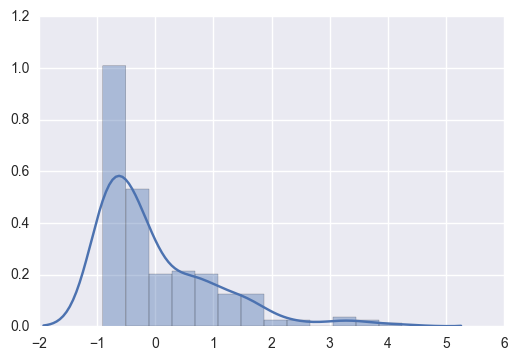

In [618]:
# Plot the distribution of opening weekend

trial = preprocessing.scale(dfm['OpeningWeekend'])
sns.distplot(trial)

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


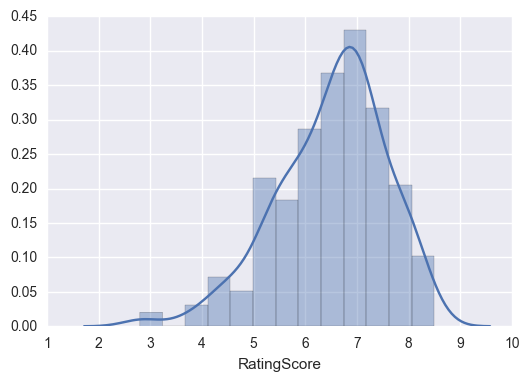

In [619]:
# Plot the distribution of rating score

sns.distplot(dfm['RatingScore'])

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


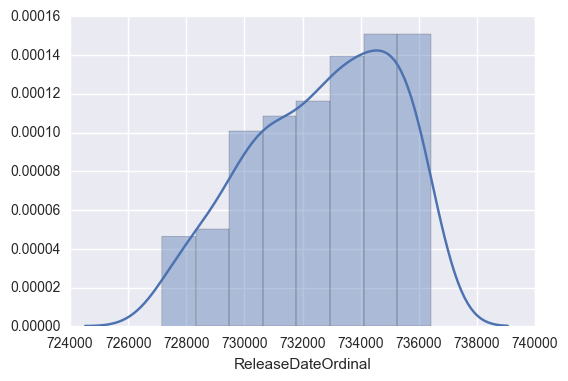

In [620]:
# Plot the distributiion of release date ordinal

sns.distplot(dfm['ReleaseDateOrdinal'])

Notice how the release date ordinal is kind of skewed to the left, so let's apply box-cox transformation to  try to eliminate the skewness

In [669]:
# box-cox transoformation of release date ordinal

box_ReleaseDateOrdinal = stats.boxcox(dfm.ReleaseDateOrdinal)[0]
box_ReleaseDateOrdinal = pd.DataFrame(box_ReleaseDateOrdinal)
box_ReleaseDateOrdinal.columns = ['BoxCoxOrdinal']
dfm = dfm.join(box_ReleaseDateOrdinal)

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


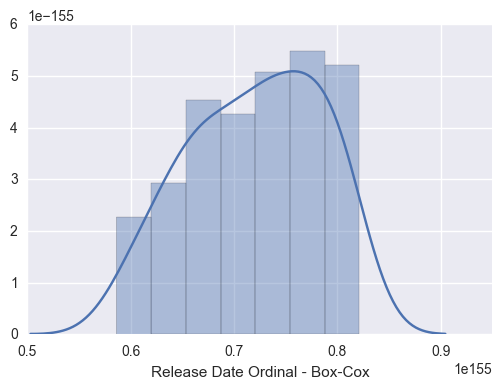

In [933]:
# Plot the box-cox tranformation of the release date ordinal

sns.distplot(stats.boxcox(dfm.ReleaseDateOrdinal)[0])
plt.xlabel('Release Date Ordinal - Box-Cox')

### Linear Regression

In [673]:
# Scale the numeric variables

dfm['BudgetS'] = preprocessing.scale(dfm[['Budget']])
dfm['OpeningWeekendS'] = preprocessing.scale(dfm[['OpeningWeekend']])
dfm['RatingScoreS'] = preprocessing.scale(dfm[['RatingScore']])
dfm['RuntimeS'] = preprocessing.scale(dfm[['Runtime']])
dfm['ReleaseDateOrdinalBCS'] = preprocessing.scale(dfm[['BoxCoxOrdinal']])


//anaconda/lib/python3.5/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [717]:
# Convert gross revenues to milion

dfm['GrossM'] = dfm['Gross'].apply(lambda x: x / 1000000)

In [719]:
# Create feature matrix (X) and target vector (y)

# Model with all the features!

y, X = patsy.dmatrices('GrossM ~ BudgetS + OpeningWeekendS + RatingScoreS + RuntimeS + ReleaseDateOrdinalBCS\
                       + MPAADummies + AwardsResultsDummies + SizeDummies + ReleaseQuarterDummies+ ReleaseMonthDummies\
                       + ReleaseDOWDummies  + ReleaseYearDummies', data=dfm, return_type="dataframe")

# Create the model

model = sm.OLS(y, X)

# Fit the model to the training set

fit = model.fit()

# Print summary statistics of the model's performance

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 GrossM   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     19.25
Date:                Thu, 02 Feb 2017   Prob (F-statistic):           2.80e-49
Time:                        22:10:09   Log-Likelihood:                -1128.2
No. Observations:                 223   AIC:                             2366.
Df Residuals:                     168   BIC:                             2554.
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   76.3956     82.661      0.924      0.357       -86.792   239.583
BudgetS                     -0.5440      4.744     -0.115      0.909        -9.909     8.821
OpeningWeekendS             66.1530      4.622     14.312      0.000        57.028    75.278
RatingScoreS                10.4389      4.709      2.217      0.028         1.143    19.735
RuntimeS                    -0.3858      4.276     -0.090      0.928        -8.827     8.055
ReleaseDateOrdinalBCS    -8.728e-14   2.96e-13     -0.295      0.769     -6.72e-13  4.97e-13
MPAADummies[0]             -46.9316     77.551     -0.605      0.546      -200.032   106.169
MPAADummies[1]             -39.6080     72.473     -0.547      0.585      -182.683   103.467
MPAADummies[2]             -37.6568     71.499     -0.527      0.599      -178.810   103.496
MPAADummies[3]             -54.4107     74.308     -0.732      0.465      -201.109    92.287
AwardsResultsDummies[0]     13.5146      9.365      1.443      0.151        -4.974    32.004
AwardsResultsDummies[1]     85.3743     14.893      5.733      0.000        55.973   114.776
SizeDummies[0]              14.4365      9.952      1.451      0.149        -5.211    34.084
SizeDummies[1]             -26.3518     10.871     -2.424      0.016       -47.812    -4.891
ReleaseQuarterDummies[0]    11.6221     22.118      0.525      0.600       -32.042    55.286
ReleaseQuarterDummies[1]    17.0666     13.239      1.289      0.199        -9.070    43.203
ReleaseQuarterDummies[2]    19.1936     12.925      1.485      0.139        -6.322    44.709
ReleaseMonthDummies[0]       1.1223     23.067      0.049      0.961       -44.417    46.661
ReleaseMonthDummies[1]      15.5205     20.244      0.767      0.444       -24.444    55.485
ReleaseMonthDummies[2]      15.4592     13.621      1.135      0.258       -11.432    42.350
ReleaseMonthDummies[3]      -2.7145     10.423     -0.260      0.795       -23.292    17.863
ReleaseMonthDummies[4]       4.3220      9.808      0.441      0.660       -15.041    23.685
ReleaseMonthDummies[5]      15.0469     15.654      0.961      0.338       -15.857    45.951
ReleaseMonthDummies[6]      10.9743     19.964      0.550      0.583       -28.438    50.386
ReleaseMonthDummies[7]       2.4920     19.215      0.130      0.897       -35.441    40.425
ReleaseMonthDummies[8]      19.7001     11.374      1.732      0.085        -2.755    42.155
ReleaseMonthDummies[9]     -17.3390      8.666     -2.001      0.047       -34.446    -0.232
ReleaseMonthDummies[10]     16.8325     10.878      1.547      0.124        -4.643    38.308
ReleaseDOWDummies[0]        69.2680     50.121      1.382      0.169       -29.681   168.217
ReleaseDOWDummies[1]        43.0253     53.382      0.806      0.421       -62.361   148.412
ReleaseDOWDumm

In [720]:
# Model with selected features, based on correlations (<0.2)!
# Dropped release year, release month, release DOW

y, X = patsy.dmatrices('GrossM ~ BudgetS + OpeningWeekendS + RatingScoreS + RuntimeS + ReleaseDateOrdinalBCS\
                       + MPAADummies + AwardsResultsDummies + SizeDummies + ReleaseQuarterDummies', data=dfm, return_type="dataframe")

# Create the model

model = sm.OLS(y, X)

# Fit the model to the training set

fit = model.fit()

# Print summary statistics of the model's performance

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 GrossM   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     68.70
Date:                Thu, 02 Feb 2017   Prob (F-statistic):           1.10e-71
Time:                        22:10:26   Log-Likelihood:                -1148.8
No. Observations:                 223   AIC:                             2330.
Df Residuals:                     207   BIC:                             2384.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   94.7317     44.602      2.124      0.035         6.800   182.664
BudgetS                     -1.1845      4.136     -0.286      0.775        -9.338     6.969
OpeningWeekendS             65.6967      3.844     17.089      0.000        58.117    73.276
RatingScoreS                 6.6909      3.938      1.699      0.091        -1.073    14.455
RuntimeS                     3.7024      3.565      1.038      0.300        -3.327    10.732
ReleaseDateOrdinalBCS    -1.181e-14   4.59e-14     -0.257      0.797     -1.02e-13  7.86e-14
MPAADummies[0]             -12.6178     49.404     -0.255      0.799      -110.018    84.782
MPAADummies[1]              -7.3477     44.604     -0.165      0.869       -95.284    80.588
MPAADummies[2]              -4.9570     44.212     -0.112      0.911       -92.120    82.206
MPAADummies[3]             -16.6755     46.421     -0.359      0.720      -108.194    74.843
AwardsResultsDummies[0]     18.1210      8.387      2.161      0.032         1.586    34.656
AwardsResultsDummies[1]     85.3687     13.520      6.314      0.000        58.715   112.022
SizeDummies[0]              15.0814      8.847      1.705      0.090        -2.360    32.523
SizeDummies[1]             -27.3908      9.758     -2.807      0.005       -46.629    -8.152
ReleaseQuarterDummies[0]     5.9615      9.252      0.644      0.520       -12.279    24.202
ReleaseQuarterDummies[1]     4.5064      9.296      0.485      0.628       -13.821    22.833
ReleaseQuarterDummies[2]     2.9448      8.634      0.341      0.733       -14.077    19.967
==============================================================================
Omnibus:                       86.794   Durbin-Watson:                   1.615
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.306
Skew:                           1.555   Prob(JB):                     1.27e-74
Kurtosis:                       8.191   Cond. No.                     4.62e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.64e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [721]:
# Drop budget and runtime since they are insignifcant

y, X = patsy.dmatrices('GrossM ~ OpeningWeekendS + RatingScoreS + ReleaseDateOrdinalBCS\
                       + MPAADummies + AwardsResultsDummies + SizeDummies + ReleaseQuarterDummies', data=dfm, return_type="dataframe")
# Create the model

model = sm.OLS(y, X)

# Fit the model to the training set

fit = model.fit()

# Print summary statistics of the model's performance

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 GrossM   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     79.53
Date:                Thu, 02 Feb 2017   Prob (F-statistic):           2.35e-73
Time:                        22:10:42   Log-Likelihood:                -1149.4
No. Observations:                 223   AIC:                             2327.
Df Residuals:                     209   BIC:                             2374.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept                   94.2450     44.463      2.120      0.035         6.591   181.899
OpeningWeekendS             65.9038      3.531     18.667      0.000        58.944    72.864
RatingScoreS                 6.7553      3.915      1.725      0.086        -0.963    14.474
ReleaseDateOrdinalBCS    -4.556e-16   1.73e-14     -0.026      0.979     -3.46e-14  3.37e-14
MPAADummies[0]             -13.6405     49.267     -0.277      0.782      -110.764    83.483
MPAADummies[1]              -8.8674     44.320     -0.200      0.842       -96.238    78.503
MPAADummies[2]              -4.9823     44.020     -0.113      0.910       -91.762    81.798
MPAADummies[3]             -16.3707     45.959     -0.356      0.722      -106.974    74.232
AwardsResultsDummies[0]     19.4055      8.258      2.350      0.020         3.125    35.686
AwardsResultsDummies[1]     88.4804     13.155      6.726      0.000        62.547   114.414
SizeDummies[0]              15.6793      8.749      1.792      0.075        -1.568    32.926
SizeDummies[1]             -26.8682      9.710     -2.767      0.006       -46.010    -7.727
ReleaseQuarterDummies[0]     6.0822      9.200      0.661      0.509       -12.054    24.219
ReleaseQuarterDummies[1]     3.8885      9.170      0.424      0.672       -14.188    21.965
ReleaseQuarterDummies[2]     2.7878      8.524      0.327      0.744       -14.017    19.592
==============================================================================
Omnibus:                       85.512   Durbin-Watson:                   1.605
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              327.395
Skew:                           1.539   Prob(JB):                     8.07e-72
Kurtosis:                       8.075   Cond. No.                     1.31e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.92e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [722]:
# Drop MPAA and Release Quarter since they are insignifcant
# BEST MODEL!!
# Variables: opening weekend, rating score, release date ordinal, awards results dummies, size dummies


y, X = patsy.dmatrices('GrossM ~ OpeningWeekendS + RatingScoreS + ReleaseDateOrdinalBCS\
                       +  AwardsResultsDummies + SizeDummies', data=dfm, return_type="dataframe")
# Create the model

model = sm.OLS(y, X)

# Fit the model to the training set

fit = model.fit()

# Print summary statistics of the model's performance

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 GrossM   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     176.9
Date:                Thu, 02 Feb 2017   Prob (F-statistic):           1.81e-80
Time:                        22:10:56   Log-Likelihood:                -1150.0
No. Observations:                 223   AIC:                             2314.
Df Residuals:                     216   BIC:                             2338.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                  90.7761      7.885     11.513      0.000        75.235   106.317
OpeningWeekendS            66.5004      3.324     20.008      0.000        59.949    73.051
RatingScoreS                5.7200      3.642      1.570      0.118        -1.459    12.899
ReleaseDateOrdinalBCS   -6.079e-14   1.05e-14     -5.800      0.000     -8.14e-14 -4.01e-14
AwardsResultsDummies[0]    19.6670      7.695      2.556      0.011         4.501    34.833
AwardsResultsDummies[1]    88.9900     12.247      7.266      0.000        64.850   113.130
SizeDummies[0]             16.0195      8.419      1.903      0.058        -0.574    32.613
SizeDummies[1]            -28.7604      9.113     -3.156      0.002       -46.722   -10.799
==============================================================================
Omnibus:                       84.846   Durbin-Watson:                   1.627
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              324.443
Skew:                           1.526   Prob(JB):                     3.53e-71
Kurtosis:                       8.060   Cond. No.                     1.98e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.23e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Cross Validation with Sklearn

In [778]:
# Scale numeric variables and combine with dummy variables

X_dfm = dfm[['OpeningWeekendS','RatingScoreS', 'ReleaseDateOrdinalBCS', 'Nominated', 'Won', 'Large','Small']]

y_dfm = dfm[['GrossM']]


In [779]:
# Baseline linear reg model score

lr = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(X_dfm, y_dfm, test_size=0.2)

lr.fit(X_train, y_train)

# Evaluate the model against the testing data

lr.score(X_test, y_test)

0.87439689179827229

In [780]:
# Show mean square error for cross validations

lr = LinearRegression()
scores = cross_val_score(lr, X_dfm, y_dfm, cv=10, scoring='mean_squared_error')
print (-scores)

[ 9860.82975034  5254.72906298  1772.361955    1128.03949183   977.23425885
  1028.97115047   916.73286702  1683.93021164   918.07125885   654.11152842]


In [781]:
# Show mean squared error

lr.fit(X_train, y_train)
y_est  = lr.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_est)
int(mse)

1191

In [782]:
# Show linear reg model coefficient

lr.coef_

array([[  6.48842719e+01,   5.92518217e+00,  -1.27897692e-13,
          1.97186579e+01,   9.71599118e+01,   1.84390181e+01,
         -2.72239657e+01]])

In [783]:
# Show linear reg model intercept

lr.intercept_

array([ 88.63846324])

#### Lasso cross validated linear regression

In [784]:
from sklearn import metrics

In [785]:
# Fit and train the lasso model using 10 folds, show optimal alpha level

lasso_cv = linear_model.LassoCV(cv = 10, normalize = False, verbose = True, random_state = 42)
lasso_cv.fit(X_train, y_train)
lasso_cv.alpha_

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.085349737962912453

In [786]:
# Show mean sqared error

y_est  = lasso_cv.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_est)
rmse = mse**0.5

int(mse)

1185

In [787]:
# Show lasso model coefficient

lasso_cv.coef_

array([ 64.93216243,   6.15213173,   0.        ,  18.94332104,
        95.65353252,  18.36281218, -27.10655973])

In [788]:
# Show lasso model intercept

lasso_cv.intercept_

89.012775090255516

#### Rigid cross validation linear regression

In [793]:
# Fit and train the rigid model using 10 folds, show optimal alpha level

from sklearn.linear_model import RidgeCV

rcv = RidgeCV(cv=10)
rcv.fit(X_train, y_train)
rcv.alpha_


1.0

In [794]:
# Show the rigid model mean squared error

y_est  = rcv.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_est)
rmse = mse**0.5

int(mse)

1162

In [795]:
# Show rigid model coefficient

rcv.coef_

array([[ 64.86903527,   7.19384878,   0.        ,  16.90426919,
         88.63073715,  19.11668917, -27.02156682]])

In [796]:
# Show rigid model intercept

rcv.intercept_

array([ 89.89031992])

#### Elastic cross validation linear regression - BEST MODEL!

In [832]:
# Fit and train the elastic model using 10 folds, show optimal alpha level

elastic_cv = linear_model.ElasticNetCV(cv = 10, normalize = False, verbose = True, random_state = 42)
elastic_cv.fit(X_train, y_train)
elastic_fit = elastic_cv.fit(X_train, y_train)
elastic_cv.alpha_

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.17069947592582488

In [934]:
elastic_cv.score(X_test, y_test)

0.87818885459770324

In [798]:
# Show the mean squared error

y_est  = elastic_cv.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_est)
rmse = mse**0.5

int(mse)

1155

In [801]:
# Show the elastic model coeffients

elastic_cv.coef_

array([ 62.33727332,  14.27646644,   0.        ,   4.26790689,
        41.74160933,  21.00110916, -23.40402198])

In [800]:
# Show the elastic model coeffients

elastic_cv.intercept_

96.024001513923636

In [ ]:
y_est_example  = elastic_cv.predict(X_test)

In [816]:
# Predict an example movie, 'inside out'

X_dfm_ex = dfm[dfm['Movie Title'] == 'Inside Out '][['OpeningWeekendS','RatingScoreS', 'ReleaseDateOrdinalBCS', 'Nominated', 'Won', 'Large','Small']]

y_dfm_ex = dfm[dfm['Movie Title'] == 'Inside Out '][['GrossM']]

y_est_ex  = elastic_cv.predict(X_dfm_ex)
print ('predicted gross revenues')
y_est_ex

predicted gross revenues


array([ 340.03844832])

In [817]:
# Compare to true revenue

print ('real gross revenue')
print ('356')

real gross revenue
356


### Visualization

#### Predicted Y vs actual Y

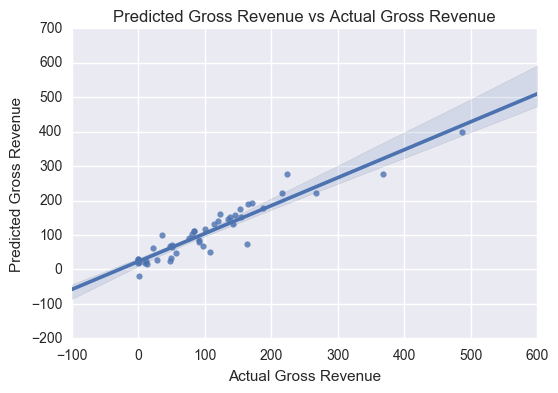

In [830]:
y_est  = elastic_cv.predict(X_test)
y_actual = y_test
sns.regplot(y_actual, y_est)
plt.title('Predicted Gross Revenue vs Actual Gross Revenue')
plt.xlabel('Actual Gross Revenue')
plt.ylabel('Predicted Gross Revenue')

#### Residual plot

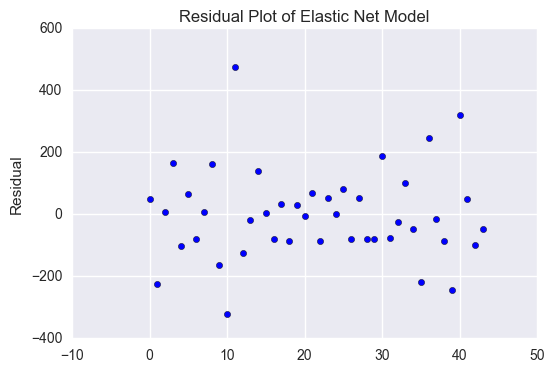

In [862]:
# THIS MIGHT BE WRONG DUE TO INDEXING
# Plot the residuals

combined = pd.DataFrame(y_est).join(y_actual)
diff = combined['GrossM'] - combined['GrossM'].shift(-1)

list_a = list(range(89))

plt.scatter(list_a, diff)
plt.title('Residual Plot of Elastic Net Model')
plt.ylabel('Residual')